In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks

In [2]:
using Plots

In [3]:
using DifferentialEquations

In [4]:
n_x = 101
n_y = 101
n_vsa = 1

1

In [5]:
repeats = 6
tspan = (0.0, repeats*1.0)

(0.0, 6.0)

In [6]:
phases = collect([[x, y] for x in range(-1.0, 1.0, n_x), y in range(-1.0, 1.0, n_y)]) |> stack
phases = reshape(phases, (1,2,:));

In [7]:
b = v_bind(phases, dims=2);

In [8]:
ub = v_unbind(phases[1:1,1:1,:], phases[1:1,2:2,:]);

In [9]:
spk_args = SpikingArgs(t_window=0.01, dt = 0.01, solver = Tsit5())

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.02 (V)


In [10]:
tbase = collect(tspan[1]:spk_args.dt:tspan[2]);

In [11]:
st_x = phase_to_train(phases[1:1,1:1,:], spk_args, repeats = repeats)
st_y = phase_to_train(phases[1:1,2:2,:], spk_args, repeats = repeats)

Spike Train: (1, 1, 10201) with 61206 spikes.

In [17]:
import .PhasorNetworks: v_bind, neuron_constant, phase_memory, find_spikes_rf

function v_bind(x::SpikeTrain, y::SpikeTrain; tspan::Tuple{<:Real, <:Real} = (0.0, 10.0), spk_args::SpikingArgs = default_spk_args(), return_solution::Bool = false, unbind::Bool=false, automatch::Bool=true)
    if !automatch
        if check_offsets(x::SpikeTrain, y::SpikeTrain) @warn "Offsets between spike trains do not match - may not produce desired phases" end
    else
        x, y = match_offsets(x, y)
    end

    #set up functions to define the neuron'sa differential equations
    k = neuron_constant(spk_args)
    tbase = tspan[1]:spk_args.dt:tspan[2]

    #get the number of batches & output neurons
    output_shape = x.shape

    #find the complex state induced by the spikes
    sol_x = phase_memory(x, tspan=tspan, spk_args=spk_args)
    sol_y = phase_memory(y, tspan=tspan, spk_args=spk_args)

    tbase = unique!(sort(cat(sol_x.t, sol_y.t, dims=1)))

    #create a reference oscillator to generate complex values for each moment in time
    u_ref = t -> phase_to_potential(0.0, t, x.offset, spk_args)

    #find the first chord
    chord_x = t -> sol_x(t)
    #find the second chord
    if unbind
        chord_y = t -> sol_x(t) .* conj.((sol_y(t) .- u_ref(t))) .* u_ref(t)
    else
        chord_y = t -> sol_x(t) .* (sol_y(t) .- u_ref(t)) .* conj(u_ref(t))
    end

    sol_output = t -> chord_x(t) .+ chord_y(t)
    
    if return_solution
        return sol_output
    end

    u_output = Array(sol_output.(tbase))
    indices, times = find_spikes_rf(u_output, tbase, spk_args, dim=ndims(u_output))
    #construct the spike train and call for the next layer
    train = SpikeTrain(indices, times, output_shape, x.offset + spiking_offset(spk_args))
    return train
end

v_bind (generic function with 4 methods)

In [15]:
@time sol_out = v_bind(st_x, st_y, tspan=tspan, spk_args=spk_args, return_solution=true)

 32.587483 seconds (19.98 M allocations: 114.715 GiB, 21.80% gc time, 9.55% compilation time)


#21 (generic function with 1 method)

In [18]:
@time spk_out = v_bind(st_x, st_y, tspan=tspan, spk_args=spk_args, return_solution=false)

LoadError: MethodError: no method matching sign(::Array{Float64, 3})

[0mClosest candidates are:
[0m  sign([91m::Unsigned[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mnumber.jl:163[24m[39m
[0m  sign([91m::Rational[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrational.jl:270[24m[39m
[0m  sign([91m::AbstractIrrational[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mirrationals.jl:157[24m[39m
[0m  ...


In [ ]:
typeof(sol_out) <: Function

true

In [ ]:
tbase = 0.0:0.01:6.0 |> collect

601-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1
 0.11
 0.12
 ⋮
 5.89
 5.9
 5.91
 5.92
 5.93
 5.94
 5.95
 5.96
 5.97
 5.98
 5.99
 6.0

In [ ]:
sol_out.(tbase)

In [16]:
i, t = find_spikes_rf(sol_out)

LoadError: MethodError: no method matching find_spikes_rf(::var"#10#15"{var"#7#12"{ODESolution{ComplexF32, 4, Vector{Array{ComplexF32, 3}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Array{ComplexF32, 3}}}, ODEProblem{Array{ComplexF32, 3}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, ODEFunction{false, SciMLBase.AutoSpecialize, Main.PhasorNetworks.var"#dzdt#12"{SpikingArgs, SpikeTrain, ComplexF64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, SymbolicIndexingInterface.SymbolCache{Nothing, Nothing, Nothing}}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, OrdinaryDiffEq.InterpolationData{ODEFunction{false, SciMLBase.AutoSpecialize, Main.PhasorNetworks.var"#dzdt#12"{SpikingArgs, SpikeTrain, ComplexF64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, SymbolicIndexingInterface.SymbolCache{Nothing, Nothing, Nothing}}, Vector{Array{ComplexF32, 3}}, Vector{Float64}, Vector{Vector{Array{ComplexF32, 3}}}, OrdinaryDiffEq.Tsit5ConstantCache, Nothing}, SciMLBase.DEStats, Nothing}}})

[0mClosest candidates are:
[0m  find_spikes_rf([91m::ODESolution[39m, [91m::SpikingArgs[39m; dim)
[0m[90m   @[39m [35mMain.PhasorNetworks[39m [90m~/.julia/dev/PhasorNetworks/src/[39m[90m[4mspiking.jl:167[24m[39m
[0m  find_spikes_rf([91m::AbstractArray[39m, [91m::AbstractVector[39m, [91m::SpikingArgs[39m; dim)
[0m[90m   @[39m [35mMain.PhasorNetworks[39m [90m~/.julia/dev/PhasorNetworks/src/[39m[90m[4mspiking.jl:175[24m[39m


In [95]:
typeof(sol_out) <: Function

true

In [96]:
@time sol_out.(tbase)

  4.432895 seconds (15.77 M allocations: 5.199 GiB, 17.40% gc time, 69.81% compilation time)


601-element Vector{Array{ComplexF64, 3}}:
 [0.0 + 0.0im;;; 0.0 + 0.0im;;; 0.0 + 0.0im;;; … ;;; 0.0 + 0.0im;;; 0.0 + 0.0im;;; 0.0 + 0.0im]
 [-9.943524933643012e-5 - 3.1182821422660184e-9im;;; -9.943541796412353e-5 + 2.0840935219452496e-9im;;; -9.844698956661645e-5 + 7.217958025110965e-9im;;; … ;;; 0.0 + 0.0im;;; 0.0 - 4.591774807899561e-41im;;; 0.0 + 3.4438311059246704e-41im]
 [-0.00039261882760755623 - 1.3138342238065356e-7im;;; -0.0003945828829526078 - 4.950239075639587e-8im;;; -0.0003926240362462745 + 3.28817521986699e-8im;;; … ;;; -1.1754943508222875e-38 + 1.4693679385278594e-39im;;; 0.0 - 1.285696946211877e-39im;;; -1.4693679385278594e-39 - 1.8367099231598242e-40im]
 [-0.0008657343968180679 - 1.0580836610719555e-6im;;; -0.0008743831724016063 - 6.576451533468058e-7im;;; -0.0008743964899261998 - 2.4658830226733167e-7im;;; … ;;; 0.0 - 5.877471754111438e-39im;;; 1.1754943508222875e-38 - 2.938735877055719e-39im;;; 5.877471754111438e-39 + 0.0im]
 [-0.001497644226758299 - 4.49692189639742

In [97]:
@time u = stack(sol_out.(tbase));

  1.326980 seconds (79.36 k allocations: 4.389 GiB, 40.92% gc time)


In [98]:
u |> size

(1, 1, 10201, 601)

In [99]:
using .PhasorNetworks: find_spikes_rf, normalize_potential, spiking_offset

In [100]:
u2 = normalize_potential.(u);

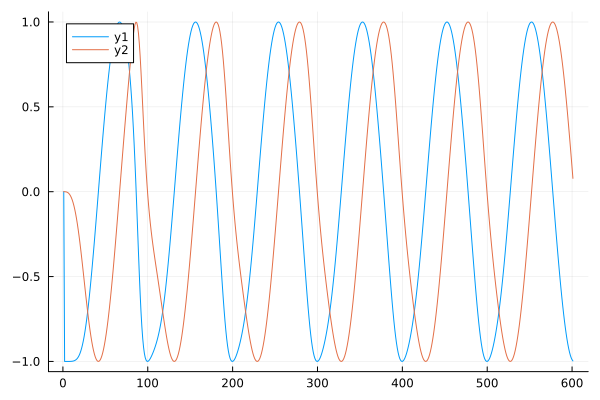

In [101]:
plot(real.(u2[1,1,1,:]))
plot!(imag.(u2[1,1,1,:]))

In [103]:
size(u2)

(1, 1, 10201, 601)

In [105]:
rec_phases = potential_to_phase(u2, tbase, dim=4, spk_args=spk_args);

In [106]:
rec_phases |> size

(1, 1, 10201, 601)

In [108]:
fp2 = rec_phases[:,:,:,end];

In [118]:
err_2 = vec(b) .- vec(fp2);

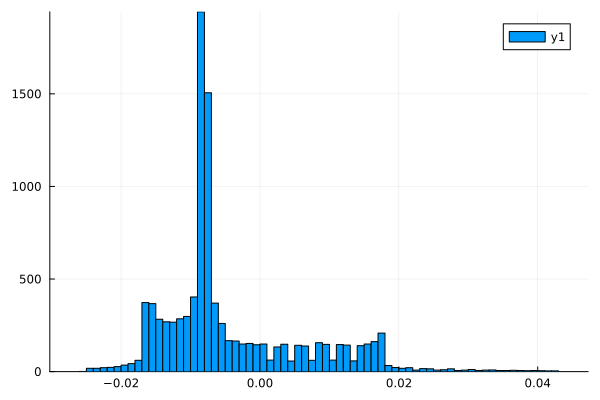

In [121]:
histogram(filter(x -> abs(x) < 0.25, err_2))

In [78]:
spk = find_spikes_rf(u2, tbase, spk_args, dim=-1)

(CartesianIndex{3}[CartesianIndex(1, 1, 1113), CartesianIndex(1, 1, 1117), CartesianIndex(1, 1, 1120), CartesianIndex(1, 1, 1214), CartesianIndex(1, 1, 1315), CartesianIndex(1, 1, 1416), CartesianIndex(1, 1, 1517), CartesianIndex(1, 1, 1618), CartesianIndex(1, 1, 1719), CartesianIndex(1, 1, 1820)  …  CartesianIndex(1, 1, 9026), CartesianIndex(1, 1, 9126), CartesianIndex(1, 1, 9226), CartesianIndex(1, 1, 9326), CartesianIndex(1, 1, 9426), CartesianIndex(1, 1, 9526), CartesianIndex(1, 1, 9727), CartesianIndex(1, 1, 9827), CartesianIndex(1, 1, 9926), CartesianIndex(1, 1, 10127)], [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01  …  5.99, 5.99, 5.99, 5.99, 5.99, 5.99, 5.99, 5.99, 5.99, 5.99])

In [79]:
train = SpikeTrain(spk[1], spk[2], size(u2)[1:end-1], spiking_offset(spk_args))

Spike Train: (1, 1, 10201) with 69487 spikes.

In [80]:
phase = train_to_phase(train, spk_args);

In [81]:
final_phase = phase[end-1,:,:,:] |> vec;

In [82]:
rep_err = final_phase .- (b |> vec);

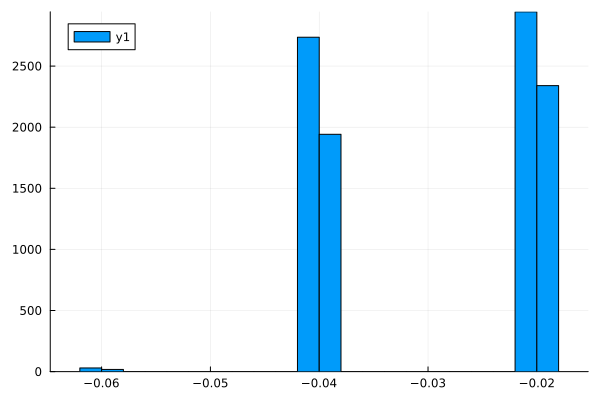

In [83]:
histogram(filter(x -> abs.(x) < 1.0, rep_err))

In [84]:
ang_err = sin.(pi .* rep_err);

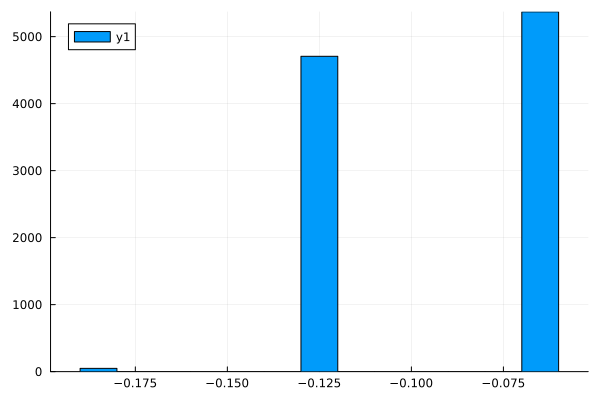

In [85]:
histogram(ang_err)

In [67]:
using Optim

In [53]:
function refine_times(sol::Function, train::SpikeTrain)
    times = train.times
    

LoadError: syntax: incomplete: "function" at In[53]:1 requires end